# Delta School District - Data And Systems Analyst - Technical Assessment 
### Completed by: Waleed Mahmood

Loading in the necessary libraries.

In [1]:
import sqlite3
import pandas as pd
import requests
import matplotlib.pyplot as plt 

### Fetch the Data
- I will use the World Bank's API Call structure to call `Birth rate data (per 1000 people)` and `Total population data`.
- In order to have modular code, I have created a function that takes in a url and returns our required data.
- I will then rename our columns for better understanding.

In [2]:
def fetch_data(url):
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()[1]  # [0] is metadata, [1] is data
    df = pd.json_normalize(data)
    df = df[['country.value', 'countryiso3code', 'date', 'value']]
    return df

In [3]:
birth_rate_url = "https://api.worldbank.org/v2/country/all/indicator/SP.DYN.CBRT.IN?format=json&per_page=30000"
population_url = "https://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL?format=json&per_page=30000"

birth_rate_df = fetch_data(birth_rate_url)
population_df = fetch_data(population_url)
birth_rate_df.rename(columns = {
    'country.value': 'Country_value',
    'countryiso3code': 'Country_code',
    'date': 'Year',
    'value': 'Birth Rate'}, inplace = True)
population_df.rename(columns = {
    'country.value': 'Country_value',
    'countryiso3code': 'Country_code',
    'date': 'Year',
    'value': 'Population'}, inplace = True)


### Drop Null Values 
This is done so that there are no null values that are used in our probability calculations later on.

In [4]:
birth_rate_df.dropna(inplace = True)
population_df.dropna(inplace = True)

### Save the data into a local database

In [5]:
sql_connection = sqlite3.connect('data/world_birth_data.db')
birth_rate_df.to_sql('birth_rate', sql_connection, index=False, if_exists='replace')
population_df.to_sql('population', sql_connection, index=False, if_exists='replace')
sql_connection.close()

### Load the data and create a merged table

The following SQL query will do an INNER JOIN on `Country_value`, `Country_code` and `Year` to get both the **birth rates** and **population data** in one table.

In [6]:
sql_connection = sqlite3.connect('data/world_birth_data.db')
query = """SELECT 
            b.Country_value, 
            b.Country_code, 
            b.Year, 
            b.[Birth Rate] AS Birth_Rate_per_1000, 
            p.Population
        FROM birth_rate AS b
        INNER JOIN population AS p
            ON b.Country_value = p.Country_value 
            AND b.Country_code = p.Country_code 
            AND b.Year = p.Year"""
df = pd.read_sql(query, sql_connection)
# df.head()

**Note:** Another method for merging the dataframes through the `pandas` library would be: <br>
`df = pd.merge(birth_rate_df, population_df, on=['Country_value', 'Country_code', 'Year'])`

### Change the data types of the columns 
- `Population`: The values in this column are first rounded to the nearest integer and then converted to type `int`. This is done because it is not possible to have a 'fraction' of a person.
- `Year`: The values in this column are initially of type `str` and are converted to type `int`. 

In [7]:
df['Year'] = df['Year'].astype(int)
df['Population'] = df['Population'].astype(int)

Let's now save this dataframe to our local database for SQL querying later on.

In [8]:
df.to_sql('world_birth_data', sql_connection, index=False, if_exists='replace')

16930

#### Common Years check
- Below is just a check to see what years are available for all countries, so that we can work with a common range as we are doing aggregations and it would be inaccurate if there are country statistics missing for some years.

In [9]:
temp_df = df.groupby('Country_value')['Year'].agg(['min', 'max'])
# print(temp.head())

common_start = temp_df['min'].max()
common_end = temp_df['max'].min()

print(f"Common year range is {common_start}:{common_end}")

Common year range is 1990:2023


In [10]:
temp_df[temp_df['min'] == 1990]
# temp_df[temp_df['min'] != 1960]

,min,max
Country_value,,
West Bank and Gaza,1990,2023


In [11]:
df[df['Country_value'] == 'West Bank and Gaza'].head()

,Country_value,Country_code,Year,Birth_Rate_per_1000,Population
16704,West Bank and Gaza,PSE,2023,27.062,5165775
16705,West Bank and Gaza,PSE,2022,27.575,5043612
16706,West Bank and Gaza,PSE,2021,28.225,4922749
16707,West Bank and Gaza,PSE,2020,28.877,4803269
16708,West Bank and Gaza,PSE,2019,29.708,4685306


**West Bank and Gaza**, with country code `PSE`, is the only country that has data beginning from $1990$ instead of $1960$, and the population itself is very small compared to the global births in the respective years. I am going to continue with the assumption that the introduction of population data points for **West Bank and Gaza** means that there is reduced population for another `Country_code`, i.e. there is no double counting in data; thus, there is no effect on the overall global population statistics. Hence, I will continue with probability calculations for $1960$-$2023$.

### Probability Calculations

Now that we have a table with all the necessary data in our database, we can begin working on our probability calculations. Below is the SQL query to get the births in Canada and get the births globally in a one row dataframe for the year $2020$, from which we can simply calculate the probability (as a percentage).

In [12]:
query_2020 = """WITH total AS (
                    SELECT 
                        Country_value,
                        (Birth_Rate_per_1000 / 1000.0) * Population AS Births,
                        Year
                    FROM world_birth_data
                    WHERE Year = 2020)
                SELECT
                    (SELECT Year FROM total) AS Year,
                    (SELECT SUM(Births) FROM total WHERE Country_value = 'Canada') AS Canada_births,
                    (SELECT SUM(Births) FROM total) AS Total_births
                    """
df_2020 = pd.read_sql(query_2020, sql_connection)
df_2020['Probability'] = (df_2020['Canada_births']/df_2020['Total_births']) * 100
df_2020

,Year,Canada_births,Total_births,Probability
0,2020,361272.061,4.770032e+08,0.075738


**Interpretation**: The probability that a person born in 2020 was born in Canada is approximately $0.0757\%$. In other words, for every $10,000$ babies born worldwide in $2020$, roughly $7.57$ we born in Canada.

### Calculate probabilities for all years
I am going to write a for loop that will run through the range `[1960:2023]` using the query I have written previously for the probability (as a percentage) calculation of the year $2020$.

In [13]:
final_probs = []

for year in range(1960, 2024):
    query = f"""
    WITH total AS (
        SELECT 
            Country_value,
            (Birth_Rate_per_1000 / 1000.0) * Population AS Births,
            Year
        FROM world_birth_data
        WHERE Year = {year}
    )
    SELECT
        (SELECT Year FROM total) AS Year,
        (SELECT SUM(Births) FROM total WHERE Country_value = 'Canada') AS Canada_births,
        (SELECT SUM(Births) FROM total) AS Total_births
    """
    
    temp_df = pd.read_sql(query, sql_connection)
    
    temp_df['Probability'] = (temp_df['Canada_births'] / temp_df['Total_births']) * 100
    final_probs.append(temp_df)
sql_connection.close()

In [14]:
prob_df = pd.concat(final_probs)
prob_df.head()

,Year,Canada_births,Total_births,Probability
0,1960,478179.8052,6.975616e+08,0.068550
0,1961,475046.0000,6.931974e+08,0.068530
0,1962,469072.8000,6.237156e+08,0.075206
0,1963,466514.4000,6.639983e+08,0.070258
0,1964,452205.0000,6.637875e+08,0.068125


### Visualizations
We now have a dataframe with the probabilities over the years $1960$ - $2023$. Let's work on visualizing our data to see if there are some insights to be found.

In [15]:
prob_df.sort_values(by='Probability')

,Year,Canada_births,Total_births,Probability
0,1987,380831.0544,6.293395e+08,0.060513
0,1988,388480.3315,6.390111e+08,0.060794
0,1991,403738.8480,6.622143e+08,0.060968
0,1986,378454.0310,6.137141e+08,0.061666
0,1989,406424.0369,6.477462e+08,0.062744
...,...,...,...,...
0,2011,377731.4310,3.928339e+08,0.096156
0,2010,380866.1024,3.867652e+08,0.098475
0,2009,383382.7866,3.757784e+08,0.102024
0,1967,371498.4000,3.637255e+08,0.102137


In [16]:
print(prob_df['Probability'].max())
print(prob_df['Probability'].min())

0.10487019460209263
0.06051281501848963


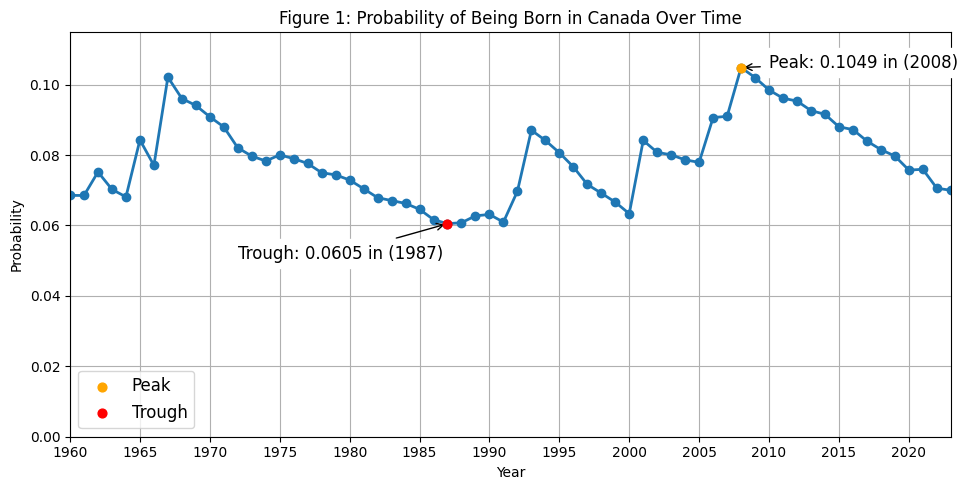

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(prob_df['Year'], prob_df['Probability'], marker = 'o', linewidth=2)
plt.title("Figure 1: Probability of Being Born in Canada Over Time")
plt.xlabel("Year")
plt.ylabel("Probability")
plt.xlim(1960, 2023)
plt.ylim(0, prob_df['Probability'].max() + 0.01)
plt.xticks(range(1960, 2025, 5))
plt.annotate(
    f"Peak: {0.1049} in ({2008})",
    xy=(2008, 0.10487019460209263),
    xytext=(2008 + 2, 0.10487019460209263),
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=12, backgroundcolor='white'
)
plt.annotate(
    f"Trough: {0.0605} in ({1987})",
    xy=(1987, 0.06051281501848963),
    xytext=(1987 - 15, 0.06051281501848963 - 0.01),
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=12, backgroundcolor='white'
)
plt.scatter([2008], [0.10487019460209263], color='orange', s=40, zorder=5, label='Peak')
plt.scatter([1987], [0.06051281501848963], color='red', s=40, zorder=5, label='Trough')
plt.legend(fontsize=12, loc = 'lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

**Figure 1 Analysis:** <br>
- `Figure 1` above displays the `probabilities` (as a percentage) that a person born in a given year was born in Canada, compared to the rest of the world, across the years $[1960:2023]$.
- As we can see, the probability fluctuates through the years, staying within the approximate range of $(0.0605:0.1049)$.
- The year in which the probability of a person born being born in Canada, compared to the rest of the world, peaked in $2008$ and was at its lowest in $1987$ - with probabilities $0.1049$ and $0.0605$, respectively.


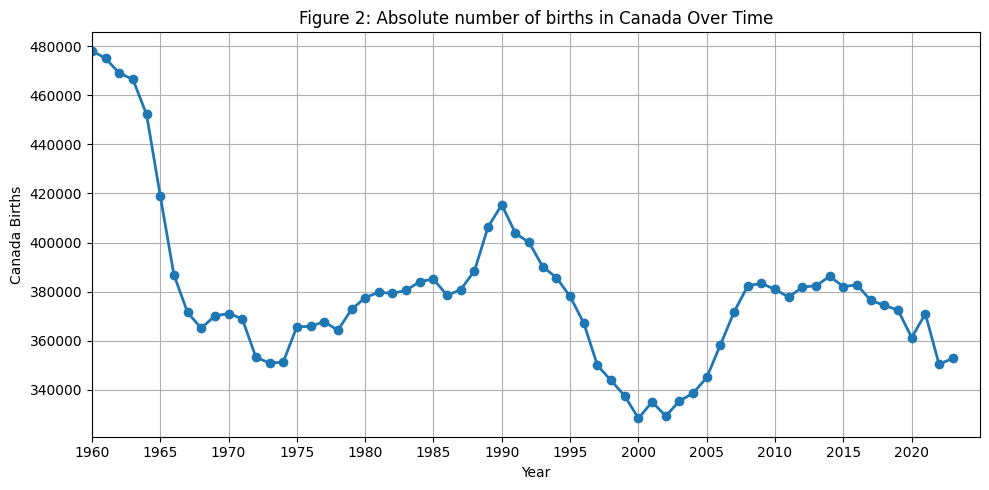

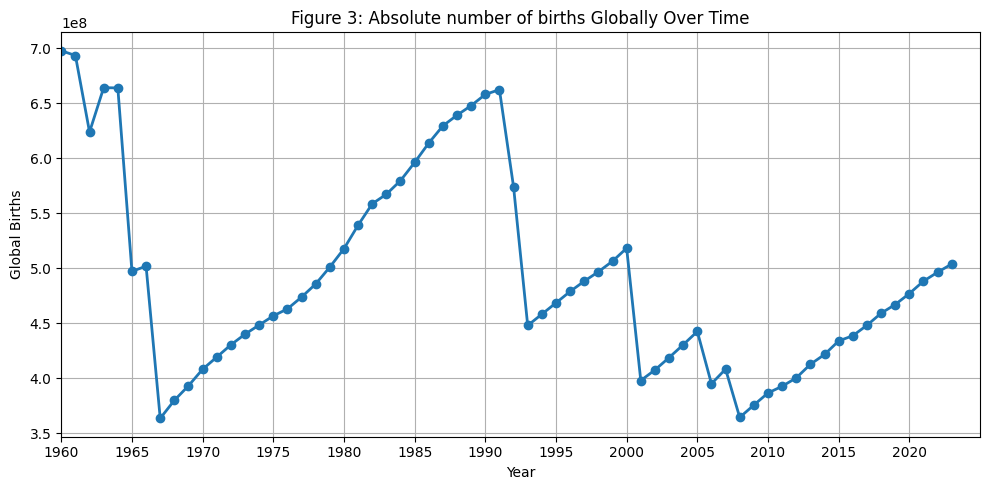

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(prob_df['Year'], prob_df['Canada_births'], marker = 'o', linewidth=2)
plt.title("Figure 2: Absolute number of births in Canada Over Time")
plt.xlabel("Year")
plt.ylabel("Canada Births")
plt.xlim(1960, 2025)
plt.xticks(range(1960, 2025, 5))
plt.grid(True)
plt.tight_layout()
plt.figure(figsize=(10, 5))
plt.plot(prob_df['Year'], prob_df['Total_births'], marker = 'o', linewidth=2)
plt.title("Figure 3: Absolute number of births Globally Over Time")
plt.xlabel("Year")
plt.ylabel("Global Births")
plt.xlim(1960, 2025)
plt.xticks(range(1960, 2025, 5))
plt.grid(True)
plt.tight_layout()
plt.show()

**Figure 2 and Figure 3 Analyses:** <br>
- `Figure 2` above displays the absolute number of births in Canada over time, while `Figure 3` above displays the absolute number of births globally over time. <br> 
- There seem to be general declines in both births in Canada and births globally between the years $1960-1967$ and $1990-2005$. The start of the decline that came in 1960 may have been caused due to an increased access to contraception, with the introduction of the birth control pill. This meant that families had greater control over reproduction.
- The decline in births in the $1990$'s may be linked to the Gulf war in $1990-1991$, which led to an economic recession causing international effects including: increased unemployment rates, reduced economic growth and tax increases. All of these are factors that would have been considered during family planning, and could have been reasons for reduced births following $1990$.
- The slight decline in births in $2021$-$2022$ may have been due to COVID-19.